In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Сlass for extracting data from a folder and processing data

In [2]:
class DataExtractionProcessing:
    """Extract data from a folder and processing data"""

    def __init__(self, folder_path, type_of_wine, test_size):        
        self.folder_path = folder_path
        self.type_of_wine = type_of_wine
        self.test_size = test_size
        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()        
        self._all_wine_sample = pd.DataFrame()
        self._folder_parsing()
        self._values_replace_by_white_wine()
        self._anomaly_removal()
        self._cut_by_bins_with_labels()
        self._train_test_split()
        self._scaling()

    def _folder_parsing(self):
        """Parsing a folder with csv files depending on the specified wine type"""
        file_list = list()

        if self.type_of_wine == 'red':
            pattern = re.compile(r'\bred')
            file_list = [pattern.search(i).string for i in os.listdir(self.folder_path) if pattern.search(i)]
        elif self.type_of_wine == 'white':
            pattern = re.compile(r'\bwhite')
            file_list = [pattern.search(i).string for i in os.listdir(self.folder_path) if pattern.search(i)]
        elif self.type_of_wine == 'all':
            pattern = re.compile(r'\bred|\bwhite')
            file_list = [pattern.search(i).string for i in os.listdir(self.folder_path) if pattern.search(i)]

        for file in file_list:
            path = os.path.join(self.folder_path, file)
            data = pd.read_csv(path, sep=None, engine='python')
            self._all_wine_sample = self._all_wine_sample.append(data, ignore_index=True)

    def _values_replace_by_white_wine(self):
        if self.type_of_wine in ('white', 'all'):
            self._all_wine_sample = self._all_wine_sample.replace({'quality': 9}, 8)

    def _anomaly_removal(self):
        clf = IsolationForest(max_samples=self._all_wine_sample.shape[0],
                              max_features=self._all_wine_sample.shape[1], random_state=42)
        clf.fit(self._all_wine_sample)
        predicted_anomaly = clf.predict(self._all_wine_sample)
        rows_of_anomalies = np.where(predicted_anomaly == -1)
        self._all_wine_sample.drop(rows_of_anomalies[0], inplace=True)
        self._all_wine_sample.reset_index(drop=True, inplace=True)

    def _cut_by_bins_with_labels(self):
        """Decrease in the number of classes"""
        rating_bins = [0, 4, 6, 10]
        rating_labels = [0, 1, 2]
        self._all_wine_sample['quality'] = pd.cut(self._all_wine_sample['quality'],
                                                  bins=rating_bins, labels=rating_labels)

    def _train_test_split(self):
        """Data splitting into training and test samples"""
        train, test = train_test_split(self._all_wine_sample, test_size=self.test_size, random_state=42)
        self.train_data = train.reset_index(drop=True)
        self.test_data = test.reset_index(drop=True)

    def _scaling(self):
        """Data normalization"""
        scaler_train = MinMaxScaler()
        names_features = self.train_data.drop(['quality'], axis=1).columns
        self.train_data[names_features] = scaler_train.fit_transform(self.train_data[names_features])
        self.test_data[names_features] = scaler_train.transform(self.test_data[names_features])

#### Class for creating a dataset from folder

In [3]:
class WineDataset(Dataset):

    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample_idx = self.data_frame.loc[idx, self.data_frame.columns != 'quality']
        target_idx = self.data_frame.loc[idx, 'quality']

        if self.transform:
            sample_idx = self.transform(np.array(sample_idx).astype(np.float32))
            target_idx = self.transform(np.array(target_idx))

        return sample_idx, target_idx

#### Class for creating a dataset from folder

#### Multilayer Perceptron Classifier

In [4]:
class ClassNet(nn.Module):
    def __init__(self):
        super(ClassNet, self).__init__()
        self.fc1 = nn.Linear(11, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [5]:
def model_training(model, criterion, optimizer, epochs, train_loader):
    """Training cycle of the model"""
    for epoch in range(epochs + 1):
        loss_epoch = []
        labels_epoch = []
        predicted_epoch = []

        for i, (inputs, labels) in enumerate(train_loader):
            labels = labels.long()
            # forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_epoch.append(loss.item())

            # clean existing gradients
            optimizer.zero_grad()
            # backpropagate the gradients
            loss.backward()
            # update the parameters
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            labels_epoch.append(labels)
            predicted_epoch.append(predicted)

        training_loss = np.mean(loss_epoch)
        score = balanced_accuracy_score(torch.cat(labels_epoch), torch.cat(predicted_epoch))
        print('Epoch [{}/{}], Loss: {:.2f}, Balanced accuracy: {:.2f}'.format(epoch, epochs, training_loss, score))

    print("----------------The model is trained-------------------- ")

In [6]:
def model_validation(model, criterion, test_loader, n_classes):
    """Model validation"""
    test_loss = []
    labels_test = []
    predicted_test = []
    actual_labels_list = []
    probabilities_list = []

    # validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        # validation loop
        for i, (inputs, labels) in enumerate(test_loader):
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss.append(loss.item())

            _, predicted = torch.max(outputs, 1)

            labels_test.append(labels)
            predicted_test.append(predicted)

            for cls in range(n_classes):
                actual_labels = labels.view_as(predicted) == cls
                actual_labels_list.append([val.item() for val in actual_labels])
                probabilities = np.exp(outputs[:, cls])
                probabilities_list.append([val.item() for val in probabilities])

    training_loss = np.mean(test_loss)
    all_labels = torch.cat(labels_test)
    all_predicted = torch.cat(predicted_test)
    score = balanced_accuracy_score(all_labels, all_predicted)

    print('Loss: {:.2f}, Balanced accuracy: {:.2f}'.format(training_loss, score))
    print('\nConfusion matrix:\n', confusion_matrix(all_labels, all_predicted))
    print('\nClassification report:\n', classification_report(all_labels, all_predicted))

    return actual_labels_list, probabilities_list

In [7]:
def plotting_roc_curves(actual_labels, probabilities, n_classes, title):
    """Compute ROC curve and ROC area for each class in each fold"""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual_labels[i], probabilities[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [8]:
def make_weights_for_balanced_classes(examples):
    """Preparation of weights for WeightedRandomSampler"""
    classes = set(examples['quality'])
    count = {key: 0 for key in classes}

    for item in examples['quality']:
        count[item] += 1

    n = float(sum(count.values()))
    weight_per_class = {key: n / float(count[key]) for key in count}
    weight = [0] * len(examples['quality'])

    for idx, val in enumerate(examples['quality']):
        weight[idx] = weight_per_class[val]

    return weight

## Red wine quality classification 

In [9]:
size = 0.2
data_extraction_processing = DataExtractionProcessing(folder_path='./dataset/', type_of_wine='red', test_size=size)

# getting processed training and test samples
train_data_red = data_extraction_processing.train_data
test_data_red = data_extraction_processing.test_data

print('Value counts for labels of train dataset:\n', train_data_red['quality'].value_counts())
print('\nValue counts for labels of test dataset:\n', test_data_red['quality'].value_counts())

Value counts for labels of train dataset:
 1    1018
2     153
0      41
Name: quality, dtype: int64

Value counts for labels of test dataset:
 1    250
2     45
0      9
Name: quality, dtype: int64


#### Classification without class balancing

In [10]:
transformation = torch.from_numpy
train_dataset_red = WineDataset(train_data_red, transform=transformation)
test_dataset_red = WineDataset(test_data_red, transform=transformation)

# training parameters 
net_red = ClassNet()
learning_rate = 0.001
criterion_red = nn.CrossEntropyLoss()
optimizer_red = optim.Adam(net_red.parameters(), lr=learning_rate)

batch_size_train_red = 30
batch_size_test_red = len(test_dataset_red)

train_loader_red = DataLoader(train_dataset_red, batch_size=batch_size_train_red)
test_loader_red = DataLoader(test_dataset_red, batch_size=batch_size_test_red)

In [11]:
epochs = 10
model_training(net_red, criterion_red, optimizer_red, epochs, train_loader_red)

Epoch [0/10], Loss: 0.49, Balanced accuracy: 0.38
Epoch [1/10], Loss: 0.41, Balanced accuracy: 0.43
Epoch [2/10], Loss: 0.40, Balanced accuracy: 0.44
Epoch [3/10], Loss: 0.39, Balanced accuracy: 0.45
Epoch [4/10], Loss: 0.39, Balanced accuracy: 0.45
Epoch [5/10], Loss: 0.39, Balanced accuracy: 0.45
Epoch [6/10], Loss: 0.40, Balanced accuracy: 0.45
Epoch [7/10], Loss: 0.40, Balanced accuracy: 0.44
Epoch [8/10], Loss: 0.40, Balanced accuracy: 0.44
Epoch [9/10], Loss: 0.40, Balanced accuracy: 0.44
Epoch [10/10], Loss: 0.40, Balanced accuracy: 0.44
----------------The model is trained-------------------- 


In [12]:
n_classes = 3
actual_labels_red, probabilities_red = model_validation(net_red, criterion_red, test_loader_red, n_classes)

Loss: 0.40, Balanced accuracy: 0.42

Confusion matrix:
 [[  0   9   0]
 [  1 241   8]
 [  0  32  13]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.85      0.96      0.91       250
           2       0.62      0.29      0.39        45

    accuracy                           0.84       304
   macro avg       0.49      0.42      0.43       304
weighted avg       0.79      0.84      0.80       304



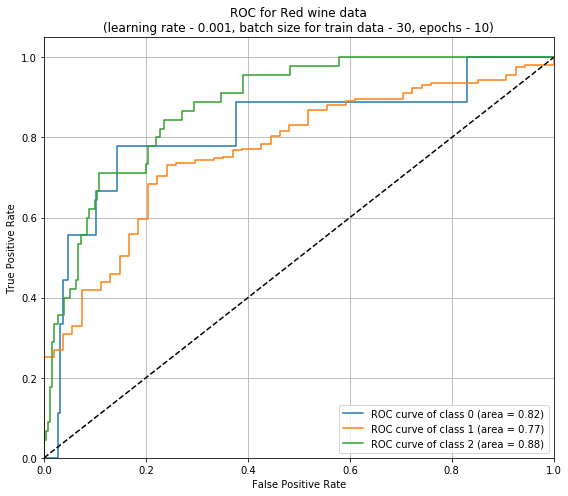

In [13]:
title = 'ROC for Red wine data\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_red, epochs)
plotting_roc_curves(actual_labels_red, probabilities_red, n_classes, title)

The values of confusion matrix and F-score show that the MLP model does not classify class 0.  
However, we can see from the dependencies of the AUC-ROC metric that the model defines all classes well.

#### Classification with class balancing

In [14]:
transformation = torch.from_numpy
train_data_balanced_red = WineDataset(train_data_red, transform=transformation)
test_data_balanced_red = WineDataset(test_data_red, transform=transformation)

# training parameters 
net_red_balanced = ClassNet()
learning_rate = 0.001
criterion_balanced = nn.CrossEntropyLoss()
optimizer_balanced = optim.Adam(net_red_balanced.parameters(), lr=learning_rate)

batch_size_train_red = 30
batch_size_test_red = len(test_data_balanced_red)

# weights for balancing the training data set classes
weights_train_red = make_weights_for_balanced_classes(train_data_balanced_red.data_frame)
sampler_train_red = torch.utils.data.sampler.WeightedRandomSampler(weights_train_red, len(weights_train_red))

train_loader_balanced_red = DataLoader(train_data_balanced_red, batch_size=batch_size_train_red, sampler=sampler_train_red)
test_loader_balanced_red = DataLoader(test_data_balanced_red, batch_size=batch_size_test_red)

In [15]:
epochs = 15
model_training(net_red_balanced, criterion_balanced, optimizer_balanced, epochs, train_loader_balanced_red)

Epoch [0/15], Loss: 0.84, Balanced accuracy: 0.58
Epoch [1/15], Loss: 0.78, Balanced accuracy: 0.64
Epoch [2/15], Loss: 0.77, Balanced accuracy: 0.65
Epoch [3/15], Loss: 0.73, Balanced accuracy: 0.65
Epoch [4/15], Loss: 0.74, Balanced accuracy: 0.66
Epoch [5/15], Loss: 0.75, Balanced accuracy: 0.63
Epoch [6/15], Loss: 0.76, Balanced accuracy: 0.64
Epoch [7/15], Loss: 0.72, Balanced accuracy: 0.66
Epoch [8/15], Loss: 0.70, Balanced accuracy: 0.67
Epoch [9/15], Loss: 0.73, Balanced accuracy: 0.66
Epoch [10/15], Loss: 0.73, Balanced accuracy: 0.65
Epoch [11/15], Loss: 0.68, Balanced accuracy: 0.68
Epoch [12/15], Loss: 0.70, Balanced accuracy: 0.67
Epoch [13/15], Loss: 0.70, Balanced accuracy: 0.68
Epoch [14/15], Loss: 0.73, Balanced accuracy: 0.67
Epoch [15/15], Loss: 0.73, Balanced accuracy: 0.68
----------------The model is trained-------------------- 


In [16]:
n_classes = 3
actual_labels_red_balanced, probabilities_red_balanced = model_validation(net_red_balanced, criterion_balanced, 
                                                                          test_loader_balanced_red, n_classes)

Loss: 0.79, Balanced accuracy: 0.69

Confusion matrix:
 [[  7   2   0]
 [ 60 145  45]
 [  4   9  32]]

Classification report:
               precision    recall  f1-score   support

           0       0.10      0.78      0.17         9
           1       0.93      0.58      0.71       250
           2       0.42      0.71      0.52        45

    accuracy                           0.61       304
   macro avg       0.48      0.69      0.47       304
weighted avg       0.83      0.61      0.67       304



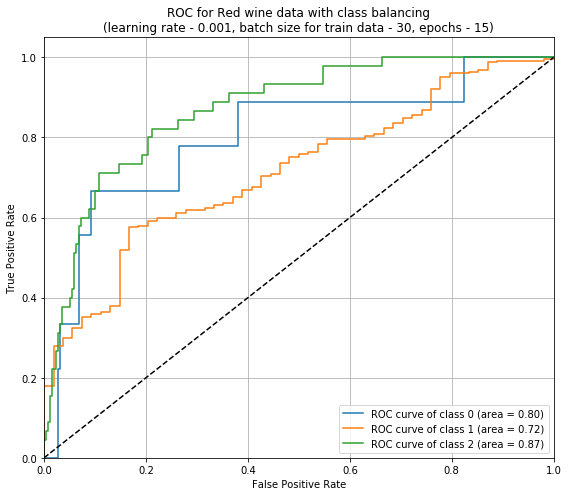

In [17]:
title = 'ROC for Red wine data with class balancing\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_red, epochs)
plotting_roc_curves(actual_labels_red_balanced, probabilities_red_balanced, n_classes, title)

Balancing of classes allowed to increase Balanced accuracy, F-score, some values of confusion matrix and AUC-ROC metrics on the red wine dataset.

___________

## White wine quality classification 

In [18]:
size = 0.2
data_extraction_processing = DataExtractionProcessing(folder_path='./dataset/', type_of_wine='white', test_size=size)

# getting processed training and test samples
train_data_white = data_extraction_processing.train_data
test_data_white = data_extraction_processing.test_data

print('Value counts for labels of train dataset:\n', train_data_white['quality'].value_counts())
print('\nValue counts for labels of test dataset:\n', test_data_white['quality'].value_counts())

Value counts for labels of train dataset:
 1    2880
2     856
0     118
Name: quality, dtype: int64

Value counts for labels of test dataset:
 1    735
2    191
0     38
Name: quality, dtype: int64


#### Classification without class balancing

In [19]:
transformation = torch.from_numpy
train_dataset_white = WineDataset(train_data_white, transform=transformation)
test_dataset_white = WineDataset(test_data_white, transform=transformation)

# training parameters 
net_white = ClassNet()
learning_rate = 0.0005
criterion_white = nn.CrossEntropyLoss()
optimizer_white = optim.Adam(net_white.parameters(), lr=learning_rate)

batch_size_train_white = 30
batch_size_test_white = len(test_dataset_white)

train_loader_white = DataLoader(train_dataset_white, batch_size=batch_size_train_white)
test_loader_white = DataLoader(test_dataset_white, batch_size=batch_size_test_white)

In [20]:
epochs = 10
model_training(net_white, criterion_white, optimizer_white, epochs, train_loader_white)

Epoch [0/10], Loss: 0.61, Balanced accuracy: 0.38
Epoch [1/10], Loss: 0.57, Balanced accuracy: 0.40
Epoch [2/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [3/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [4/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [5/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [6/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [7/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [8/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [9/10], Loss: 0.56, Balanced accuracy: 0.41
Epoch [10/10], Loss: 0.56, Balanced accuracy: 0.41
----------------The model is trained-------------------- 


In [21]:
n_classes = 3
actual_labels_white, probabilities_white = model_validation(net_white, criterion_white, 
                                                            test_loader_white, n_classes)

Loss: 0.53, Balanced accuracy: 0.44

Confusion matrix:
 [[  0  37   1]
 [  0 645  90]
 [  0 104  87]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.82      0.88      0.85       735
           2       0.49      0.46      0.47       191

    accuracy                           0.76       964
   macro avg       0.44      0.44      0.44       964
weighted avg       0.72      0.76      0.74       964



c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


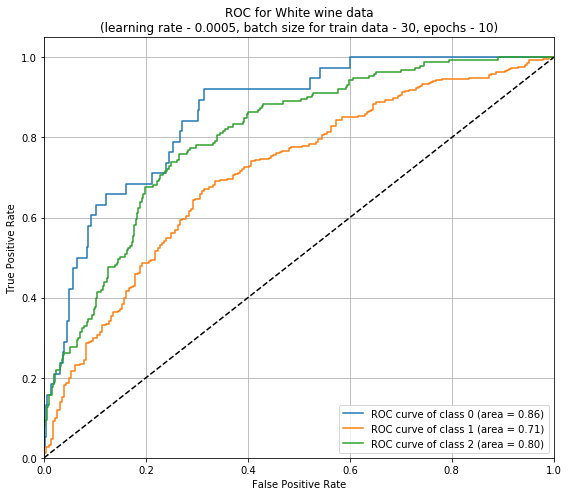

In [22]:
title = 'ROC for White wine data\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_white, epochs)
plotting_roc_curves(actual_labels_white, probabilities_white, n_classes, title)

The values of confusion matrix and F-score show that the MLP model also poorly classifies classes 0 and 2.  
From the dependencies of the AUC-ROC metric we can see that the model defines all classes equally well.

#### Classification with class balancing

In [23]:
transformation = torch.from_numpy
train_data_balanced_white = WineDataset(train_data_white, transform=transformation)
test_data_balanced_white = WineDataset(test_data_white, transform=transformation)

# training parameters 
net_white_balanced = ClassNet()
learning_rate = 0.001
criterion_white_balanced = nn.CrossEntropyLoss()
optimizer_white_balanced = optim.Adam(net_white_balanced.parameters(), lr=learning_rate)

batch_size_train_white = 30
batch_size_test_white = len(test_data_balanced_white)

# weights for balancing the training data set classes
weights_train_white = make_weights_for_balanced_classes(train_data_balanced_white.data_frame)
sampler_train_white = torch.utils.data.sampler.WeightedRandomSampler(weights_train_white, len(weights_train_white))

train_loader_balanced_white = DataLoader(train_data_balanced_white, batch_size=batch_size_train_white, sampler=sampler_train_white)
test_loader_balanced_white = DataLoader(test_data_balanced_white, batch_size=batch_size_test_white)

In [24]:
epochs = 15
model_training(net_white_balanced, criterion_white_balanced, optimizer_white_balanced, epochs, train_loader_balanced_white)

Epoch [0/15], Loss: 0.92, Balanced accuracy: 0.57
Epoch [1/15], Loss: 0.86, Balanced accuracy: 0.61
Epoch [2/15], Loss: 0.87, Balanced accuracy: 0.61
Epoch [3/15], Loss: 0.85, Balanced accuracy: 0.62
Epoch [4/15], Loss: 0.85, Balanced accuracy: 0.62
Epoch [5/15], Loss: 0.86, Balanced accuracy: 0.61
Epoch [6/15], Loss: 0.85, Balanced accuracy: 0.63
Epoch [7/15], Loss: 0.84, Balanced accuracy: 0.62
Epoch [8/15], Loss: 0.84, Balanced accuracy: 0.62
Epoch [9/15], Loss: 0.85, Balanced accuracy: 0.63
Epoch [10/15], Loss: 0.85, Balanced accuracy: 0.63
Epoch [11/15], Loss: 0.87, Balanced accuracy: 0.60
Epoch [12/15], Loss: 0.84, Balanced accuracy: 0.62
Epoch [13/15], Loss: 0.85, Balanced accuracy: 0.62
Epoch [14/15], Loss: 0.85, Balanced accuracy: 0.63
Epoch [15/15], Loss: 0.85, Balanced accuracy: 0.61
----------------The model is trained-------------------- 


In [25]:
n_classes = 3
actual_labels_white_balanced, probabilities_white_balanced = model_validation(net_white_balanced, criterion_white_balanced, 
                                                                              test_loader_balanced_white, n_classes)

Loss: 0.87, Balanced accuracy: 0.67

Confusion matrix:
 [[ 28   9   1]
 [143 380 212]
 [  7  38 146]]

Classification report:
               precision    recall  f1-score   support

           0       0.16      0.74      0.26        38
           1       0.89      0.52      0.65       735
           2       0.41      0.76      0.53       191

    accuracy                           0.57       964
   macro avg       0.48      0.67      0.48       964
weighted avg       0.77      0.57      0.61       964



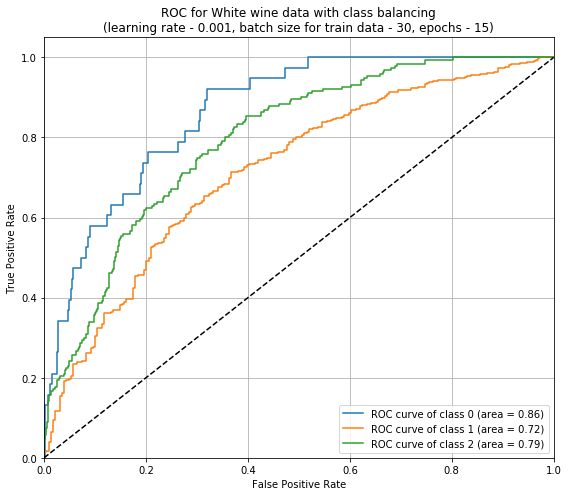

In [26]:
title = 'ROC for White wine data with class balancing\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_white, epochs)
plotting_roc_curves(actual_labels_white_balanced, probabilities_white_balanced, n_classes, title)

As a result of balancing the classes according to the confusion matrix and F-score values, we can see that the model has become better at classifying classes 0 and 2.
This did not affect AUC-ROC metrics for white wine data set.

___________

## Classification of wine quality on a joint dataset

In [27]:
size = 0.2
data_extraction_processing = DataExtractionProcessing(folder_path='./dataset/', type_of_wine='all', test_size=size)

# getting processed training and test samples
train_data_all = data_extraction_processing.train_data
test_data_all = data_extraction_processing.test_data

print('Value counts for labels of train dataset:\n', train_data_all['quality'].value_counts())
print('\nValue counts for labels of test dataset:\n', test_data_all['quality'].value_counts())

Value counts for labels of train dataset:
 1    3946
2    1004
0     169
Name: quality, dtype: int64

Value counts for labels of test dataset:
 1    976
2    258
0     46
Name: quality, dtype: int64


#### Classification without class balancing

In [28]:
transformation = torch.from_numpy
train_dataset_all = WineDataset(train_data_all, transform=transformation)
test_dataset_all = WineDataset(test_data_all, transform=transformation)

# training parameters 
net_all = ClassNet()
learning_rate = 0.0005
criterion_all = nn.CrossEntropyLoss()
optimizer_all = optim.Adam(net_all.parameters(), lr=learning_rate)

batch_size_train_all = 30
batch_size_test_all = len(test_data_all)

train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size_train_all)
test_loader_all = DataLoader(test_dataset_all, batch_size=batch_size_test_all)

In [29]:
epochs = 15
model_training(net_all, criterion_all, optimizer_all, epochs, train_loader_all)

Epoch [0/15], Loss: 0.59, Balanced accuracy: 0.37
Epoch [1/15], Loss: 0.54, Balanced accuracy: 0.40
Epoch [2/15], Loss: 0.54, Balanced accuracy: 0.40
Epoch [3/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [4/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [5/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [6/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [7/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [8/15], Loss: 0.53, Balanced accuracy: 0.41
Epoch [9/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [10/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [11/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [12/15], Loss: 0.53, Balanced accuracy: 0.40
Epoch [13/15], Loss: 0.52, Balanced accuracy: 0.40
Epoch [14/15], Loss: 0.52, Balanced accuracy: 0.40
Epoch [15/15], Loss: 0.52, Balanced accuracy: 0.40
----------------The model is trained-------------------- 


In [30]:
n_classes = 3
actual_labels_all, probabilities_all = model_validation(net_all, criterion_all, test_loader_all, n_classes)

Loss: 0.53, Balanced accuracy: 0.40

Confusion matrix:
 [[  0  45   1]
 [  0 937  39]
 [  0 199  59]]

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.79      0.96      0.87       976
           2       0.60      0.23      0.33       258

    accuracy                           0.78      1280
   macro avg       0.46      0.40      0.40      1280
weighted avg       0.73      0.78      0.73      1280



c:\python36\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


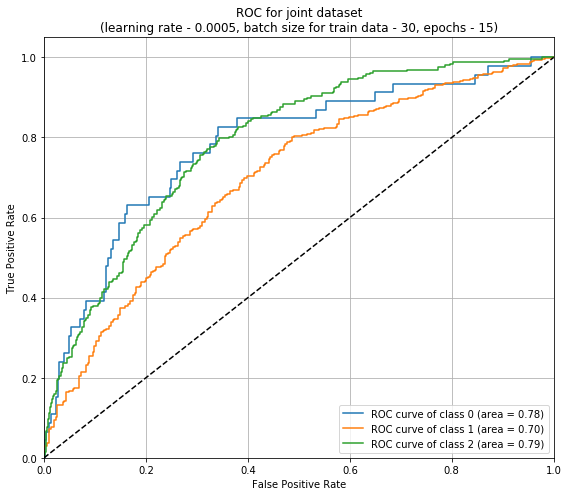

In [31]:
title = 'ROC for joint dataset\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_all, epochs)
plotting_roc_curves(actual_labels_all, probabilities_all, n_classes, title)

The values of confusion matrix and F-score show that the MLP model classifies class 1 correctly.   
From the dependencies of the AUC-ROC metric we can see that the model defines all classes equally well.

#### Classification with class balancing

In [32]:
transformation = torch.from_numpy
train_data_balanced_all = WineDataset(train_data_all, transform=transformation)
test_data_balanced_all = WineDataset(test_data_all, transform=transformation)

# training parameters 
net_all_balanced = ClassNet()
learning_rate = 0.0005
criterion_all_balanced = nn.CrossEntropyLoss()
optimizer_all_balanced = optim.Adam(net_all_balanced.parameters(), lr=learning_rate)

batch_size_train_all = 30
batch_size_test_all = len(test_data_balanced_all)

# weights for balancing the training data set classes
weights_train_all = make_weights_for_balanced_classes(train_data_balanced_all.data_frame)
sampler_train_all = torch.utils.data.sampler.WeightedRandomSampler(weights_train_all, len(weights_train_all))

train_loader_balanced_all = DataLoader(train_data_balanced_all, batch_size=batch_size_train_all, sampler=sampler_train_all)
test_loader_balanced_all = DataLoader(test_data_balanced_all, batch_size=batch_size_test_all)

In [33]:
epochs = 10
model_training(net_all_balanced, criterion_all_balanced, optimizer_all_balanced, epochs, train_loader_balanced_all)

Epoch [0/10], Loss: 0.89, Balanced accuracy: 0.58
Epoch [1/10], Loss: 0.84, Balanced accuracy: 0.60
Epoch [2/10], Loss: 0.84, Balanced accuracy: 0.61
Epoch [3/10], Loss: 0.82, Balanced accuracy: 0.62
Epoch [4/10], Loss: 0.85, Balanced accuracy: 0.60
Epoch [5/10], Loss: 0.84, Balanced accuracy: 0.61
Epoch [6/10], Loss: 0.83, Balanced accuracy: 0.61
Epoch [7/10], Loss: 0.82, Balanced accuracy: 0.62
Epoch [8/10], Loss: 0.84, Balanced accuracy: 0.61
Epoch [9/10], Loss: 0.82, Balanced accuracy: 0.62
Epoch [10/10], Loss: 0.82, Balanced accuracy: 0.62
----------------The model is trained-------------------- 


In [34]:
n_classes = 3
actual_labels_all_balanced, probabilities_all_balanced = model_validation(net_all_balanced, criterion_all_balanced, 
                                                                          test_loader_balanced_all, n_classes)

Loss: 0.97, Balanced accuracy: 0.62

Confusion matrix:
 [[ 36   6   4]
 [351 376 249]
 [ 27  52 179]]

Classification report:
               precision    recall  f1-score   support

           0       0.09      0.78      0.16        46
           1       0.87      0.39      0.53       976
           2       0.41      0.69      0.52       258

    accuracy                           0.46      1280
   macro avg       0.46      0.62      0.40      1280
weighted avg       0.75      0.46      0.52      1280



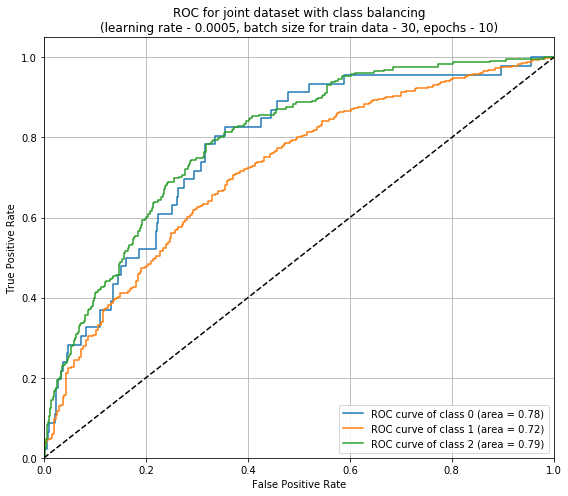

In [35]:
title = 'ROC for joint dataset with class balancing\n(learning rate - {}, ' \
        'batch size for train data - {}, epochs - {})'.format(learning_rate, batch_size_train_all, epochs)
plotting_roc_curves(actual_labels_all_balanced, probabilities_all_balanced, n_classes, title)

As a result of class balancing, some metrics have increased in comparison with unbalanced sampling. 
However, the combined data sets did not change the parameters for the better in comparison with the evaluation of data sets separately.

____